In [1]:
import GiovConfig as config
from GiovanniDataset import GiovanniDataset
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from osgeo import gdal
import cv2

/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

def apply_legal_amazon_mask(input_image: np.array, amazon_mask: np.array):
    ''' Apply Legal Amazon mask '''
    print('DEBUG apply_legal_amazon_mask')
    for i in range(input_image.shape[0]):
        # print(input_image.max(), input_image.min())
        input_image[i, :, :][amazon_mask == 2.0] = 2
        # print(input_image.max(), input_image.min())
    return input_image

def load_data(config):
    #! Loads data
    # load legal amazon limits
    am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)
    # load frames idx detail
    frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)
    # load frames deforestation area history
    deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
    deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

    # counties
    frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
    counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

    # precipitations
    precip = pd.read_csv(config.TR_RAIN_AVG)
    precip["quarter_date"] = pd.to_datetime(precip["dt"])

    # terrain position index
    tpi = pd.read_csv(config.TR_TPI, skiprows=1)\
        .rename(columns={"Unnamed: 0": "frame_id"})

    # past scores
    past_scores = pd.read_csv(config.TR_PAST_SCORES)
    past_scores["variable"] = pd.to_datetime(past_scores["variable"])

    # night lights
    night_light = pd.read_csv(config.TR_NIGHT_LIGHT)
    night_light["dt"] = pd.to_datetime(night_light["dt"])
    
    return am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light

def create_grids(am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light):
    #! create limits history grid
    time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in enumerate(config.TIME_STEPS):
        defor_area = (
            deforestation[
                deforestation["quarter_date"] == dt
            ].set_index("frame_id")["area"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)
    
    # Population and density
    county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    county_data[0] = (
        frames_county.set_index("frame_id")["populacao"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).\
        values.reshape(county_data.shape[1:])

    county_data[1] = (
        frames_county.set_index("frame_id")["densidade"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).\
        values.reshape(county_data.shape[1:])
        
    # Deforestation
    frames_counties_defor = pd.merge(
        counties_defor,
        frames_county[["frame_id", "county_id"]],
        on="county_id",
        how="right"
    )
    frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

    counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        defor_area = (
            frames_counties_defor[
                frames_counties_defor["quarter_date"] == dt
            ].set_index("frame_id")["area"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

    # Precipitations
    # create limits history grid
    precip_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        precip_sum = (
            precip[
                precip["quarter_date"] == dt
            ].set_index("frame_id")["precipitation"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        precip_time_grid[t, :, :] = precip_sum.values.reshape(counties_time_grid[0, :, :].shape)

    # Terrain
    cols = ["mean", "min", "max", "std"]
    tpi_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for icol, col in enumerate(cols):
        v = (
            tpi.set_index("frame_id")[col] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        tpi_array[icol, :, :] = v.values.reshape(tpi_array[0, :, :].shape)

    # Past Scores
    # create history grid for scores
    scores_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        t_scores = (
            past_scores[
                past_scores["variable"] == dt
            ].set_index("frame_id")["value"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        scores_time_grid[t, :, :] = t_scores.values.reshape(scores_time_grid[0, :, :].shape)
        
    # Night Lights
    # create history grid for scores
    night_time_grid = np.zeros((2, len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        avg_light = (
            night_light[
                night_light["dt"] == dt
            ].set_index("frame_id")["avg_light"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        night_time_grid[0, t, :, :] = avg_light.values.reshape(night_time_grid[0, 0, :, :].shape)
        
        max_light = (
            night_light[
                night_light["dt"] == dt
            ].set_index("frame_id")["max_light"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        night_time_grid[1, t, :, :] = max_light.values.reshape(night_time_grid[0, 0, :, :].shape)

    print(time_grid.shape, county_data.shape, night_time_grid.shape)
    return time_grid, county_data, counties_time_grid, precip_time_grid, tpi_array, scores_time_grid, night_time_grid

def plot_videos_side_by_side(video1, video2, video3, output_gif_path):
    # Determine the number of frames in the videos
    num_frames = min(video1.shape[0], video2.shape[0], video3.shape[0])

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create colorbars for each subplot
    cbar1 = fig.colorbar(ax[0].imshow(video1[0], cmap='viridis'), ax=ax[0])
    cbar2 = fig.colorbar(ax[1].imshow(video2[0], cmap='viridis'), ax=ax[1])
    cbar3 = fig.colorbar(ax[2].imshow(video3[0], cmap='viridis'), ax=ax[2])

    # Set color bar labels
    cbar1.set_label('Probabilities')
    cbar2.set_label('Probabilities')
    cbar3.set_label('Class Argmax')

    # Function to update the plot for each frame
    def update(frame):
        # Get frames from both videos
        frame1 = video1[frame]
        frame2 = video2[frame]
        frame3 = video3[frame]

        # Plot frames side by side
        ax[0].imshow(frame1, cmap='viridis')
        ax[1].imshow(frame2, cmap='viridis')
        ax[2].imshow(frame3, cmap='viridis')
        
        # Add titles to each subplot
        ax[0].set_title(f'Probs Class 0 (No Def) - Frame {frame}')
        ax[1].set_title(f'Probs Class 1 (Def) - Frame {frame}')
        ax[2].set_title(f'Class Argmax - Frame {frame}')

    # # Create animation
    # animation = FuncAnimation(fig, update, frames=num_frames, interval=100)

    # # Save animation as gif
    # animation.save(output_gif_path, writer='imagemagick', fps=1, dpi=300)

    # Display the plot (optional)
    plt.show()

In [8]:
am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light = load_data(config)
time_grid, county_data, counties_time_grid, precip_time_grid, tpi_array, scores_time_grid, night_time_grid = create_grids(am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light)
test_time_idx = range(20,28)
test_data = time_grid[test_time_idx, :, :]

28it [00:04,  5.91it/s]
28it [00:03,  7.79it/s]
28it [00:00, 35.79it/s]
28it [00:06,  4.59it/s]

(28, 1002, 778) (2, 1002, 778) (2, 28, 1002, 778)


In [26]:
mask_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/area.tif'
mask = load_tif_image(mask_path)
print(mask.shape)
mask[mask == 0.0] = 2.0
mask[mask == 1] = 0.0
print(test_data.shape)
# mask = np.resize(mask, [test_data.shape[1], test_data.shape[2]])
mask = cv2.resize(mask, [test_data.shape[2], test_data.shape[1]], interpolation=cv2.INTER_AREA)
print(mask.shape)
test_data = apply_legal_amazon_mask(test_data, mask)
print(test_data.max(), test_data.min())

(2332, 3004)
(8, 1002, 778)
(1002, 778)
DEBUG apply_legal_amazon_mask
2.0 0.0


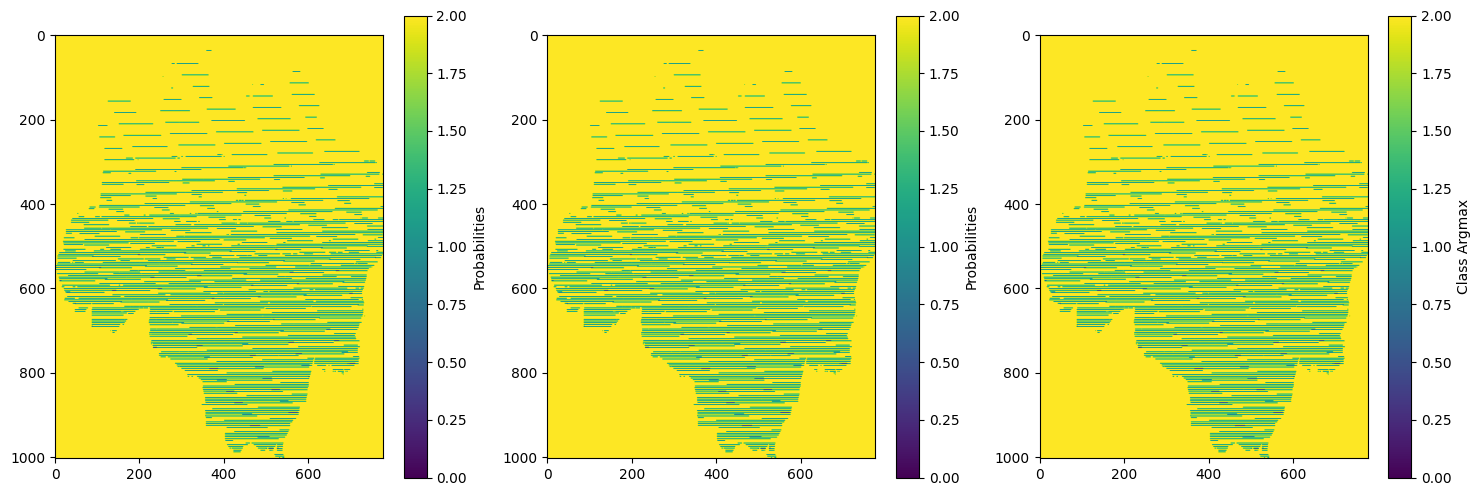

In [27]:
exp_path = Path('None')
plot_videos_side_by_side(test_data, test_data, test_data, exp_path / 'saved' / 'None.gif')

# Inspect Patches and Dataloader

In [2]:
import torch
from AmazonDataset import CustomDataset
from GiovanniDataset import GiovanniDataset
from pathlib import Path
import numpy as np
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser
from osgeo import gdal
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import geopandas as gpd
import GiovConfig as config
from prep_giov_data import prep4dataset_test
import matplotlib.pyplot as plt

In [3]:
test_data, patches_sample_train, patches_sample_val, frames_idx, county_data, counties_time_grid, \
    precip_time_grid, tpi_array, scores_time_grid, night_time_grid = prep4dataset_test(config)

counties_time_grid = None # county_defor
tpi_array = None

county_data = None
# precip_time_grid = None
# scores_time_grid = None
# night_time_grid = None

test_set = GiovanniDataset(
test_data, 
patches_sample_val, 
frames_idx, 
county_data,
counties_time_grid,
precip_time_grid,
tpi_array,
None,
scores_time_grid,
night_time_grid,
device=None
)

28it [00:03,  7.13it/s]
28it [00:03,  8.57it/s]
28it [00:00, 34.52it/s]
28it [00:05,  4.71it/s]


(28, 1002, 778) (2, 1002, 778) (2, 28, 1002, 778)


100%|██████████| 32/32 [00:03<00:00,  8.26it/s]


In [4]:
batch_size = 16
dataloader_train = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=1)

In [5]:
for i, batch in enumerate(dataloader_train):
    batch_x, batch_y = batch
    print(batch_x.shape, batch_y.shape)
    if np.mean(batch_y[:, 0, 0].detach().numpy(), axis=(0, 1, 2)) > 0.05:
        break
    

torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64]) torch.Size([16, 1, 1, 64, 64])
torch.Si

tensor(-0.0322) tensor(9.0927) tensor(-0.0487) tensor(55.7916) tensor(-0.0731) tensor(31.9800) tensor(-0.0504) tensor(45.8898)


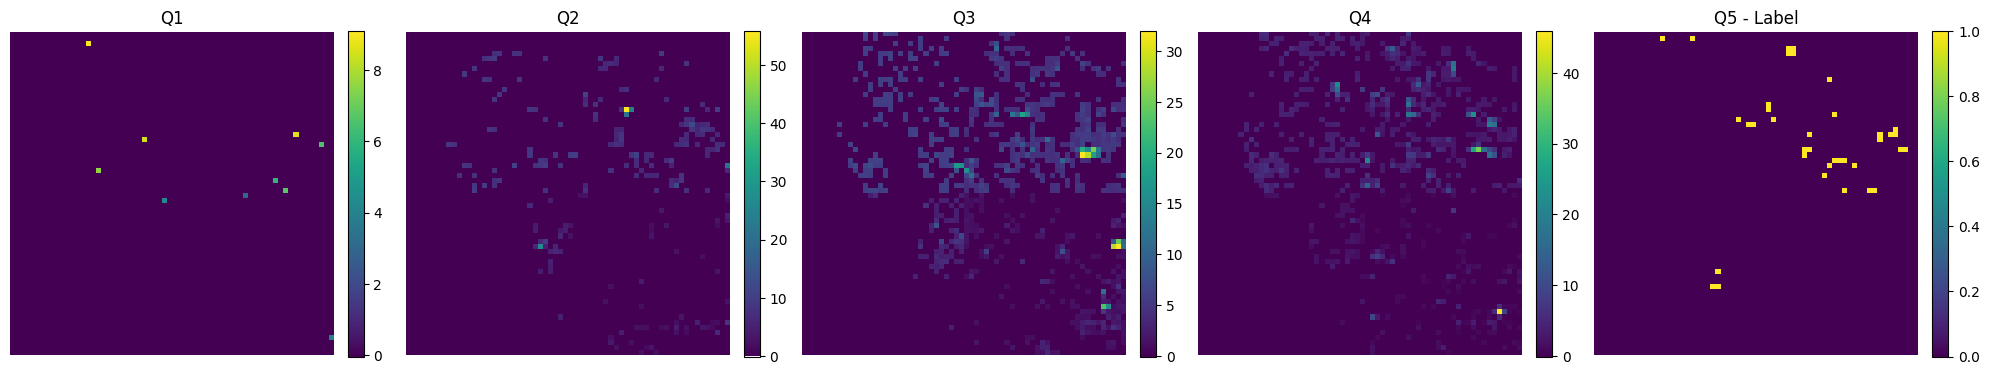

In [61]:
# # Generate sample data for five images (each with one channel)
idx_b = 10
image1 = batch_x[idx_b, 0, 0]  # Replace this with your actual image data
image2 = batch_x[idx_b, 1, 0]  # Replace this with your actual image data
image3 = batch_x[idx_b, 2, 0]  # Replace this with your actual image data
image4 = batch_x[idx_b, 3, 0]  # Replace this with your actual image data
image5 = batch_y[idx_b, 0, 0]  # Replace this with your actual image data

print(image1.min(), image1.max(), image2.min(), image2.max(), image3.min(), image3.max(), image4.min(), image4.max())
# Create a figure with five subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

# Plot each image in a separate subplot with 'viridis' colormap
im1 = axes[0].imshow(image1, cmap='viridis')
axes[0].set_title('Q1')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(image2, cmap='viridis')
axes[1].set_title('Q2')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

im3 = axes[2].imshow(image3, cmap='viridis')
axes[2].set_title('Q3')
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

im4 = axes[3].imshow(image4, cmap='viridis')
axes[3].set_title('Q4')
axes[3].axis('off')
fig.colorbar(im4, ax=axes[3], orientation='vertical', fraction=0.046, pad=0.04)

im5 = axes[4].imshow(image5, cmap='viridis')
axes[4].set_title('Q5 - Label')
axes[4].axis('off')
fig.colorbar(im5, ax=axes[4], orientation='vertical', fraction=0.046, pad=0.04)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig(f'/home/thiago/AmazonDeforestation_Prediction/OpenSTL/tst_data_sample{idx_b}.jpg', dpi=300, bbox_inches='tight')

# Model Inference

In [6]:
EX_NAME = 'custom_exp02_Pop'
# root_dir = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/Dataset/DETR_Patches')
img_path = Path('/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/test.tif')
exp_path = Path(f'/home/thiago/AmazonDeforestation_Prediction/OpenSTL/work_dirs/{EX_NAME}')

custom_training_config = {
    'pre_seq_length': 4,
    'aft_seq_length': 1,
    'total_length': 5,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 50,
    'lr': 1e-4,   
    'metrics': ['mse', 'mae', 'acc', 'Recall', 'Precision', 'f1_score'],

    'ex_name': f'{EX_NAME}', # custom_exp
    'dataname': 'custom',
    'in_shape': [4, 5, 64, 64], # T, C, H, W = self.args.in_shape
    'loss_weights': None,
    'early_stop_epoch': 10,
    'warmup_epoch': 0, #default = 0
    'sched': 'step',
    'decay_epoch': 3,
    'decay_rate': 0.5,
    'resume_from': None,
    'auto_resume': False,
    'test_time': True,
    'loss': 'focal'
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]
        
exp = BaseExperiment(args, dataloaders=(dataloader_train, None, None))

print('>'*35 + ' testing  ' + '<'*35)
exp.load_model()

pred_y = exp.infer_one_image(batch_x)

Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.7.r11.7/compiler.31442593_0
GPU 0: NVIDIA GeForce GTX 1060
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 1.13.1+cu117
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,cod

In [11]:
print(pred_y.shape)
print(batch_x.shape)
print(batch_x[0].shape)

torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 4, 5, 64, 64])
torch.Size([4, 5, 64, 64])


In [7]:
# # Generate sample data for five images (each with one channel)
idx_b = 10
image1 = batch_x[idx_b, 0, 0]  # Replace this with your actual image data
image2 = batch_x[idx_b, 1, 0]  # Replace this with your actual image data
image3 = batch_x[idx_b, 2, 0]  # Replace this with your actual image data
image4 = batch_x[idx_b, 3, 0]  # Replace this with your actual image data
image5 = batch_x[idx_b, 4, 0]  # Replace this with your actual image data

image6 = batch_y[idx_b, 0, 0]  # Replace this with your actual image data
image6_pred = pred_y[idx_b, 0, 0].cpu().detach().numpy()  # Replace this with your actual image data
th = 1.6290691375732287
image6_pred_opt = image6_pred.copy()
image6_pred_opt[image6_pred >= th] = 1
image6_pred_opt[image6_pred < th] = 0

print(image1.min(), image1.max(), image2.min(), image2.max(), image3.min(), image3.max(), image4.min(), image4.max())
# Create a figure with five subplots in one row
fig, axes = plt.subplots(1, 8, figsize=(32, 7))  # Adjust the figure size as needed

# Plot each image in a separate subplot with 'viridis' colormap
im1 = axes[0].imshow(image1, cmap='viridis')
axes[0].set_title('Q1')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(image2, cmap='viridis')
axes[1].set_title('Q2')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

im3 = axes[2].imshow(image3, cmap='viridis')
axes[2].set_title('Q3')
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

im4 = axes[3].imshow(image4, cmap='viridis')
axes[3].set_title('Q4')
axes[3].axis('off')
fig.colorbar(im4, ax=axes[3], orientation='vertical', fraction=0.046, pad=0.04)

im5 = axes[4].imshow(image5, cmap='viridis')
axes[4].set_title('Q5 - Label')
axes[4].axis('off')
fig.colorbar(im5, ax=axes[4], orientation='vertical', fraction=0.046, pad=0.04)




im6 = axes[5].imshow(image6_pred, cmap='viridis')
axes[5].set_title('Q5 - Pred')
axes[5].axis('off')
fig.colorbar(im6, ax=axes[5], orientation='vertical', fraction=0.046, pad=0.04)

im7 = axes[6].imshow(image6_pred_opt, cmap='viridis')
axes[6].set_title('Q5 - Pred Opt')
axes[6].axis('off')
fig.colorbar(im7, ax=axes[6], orientation='vertical', fraction=0.046, pad=0.04)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig(f'/home/thiago/AmazonDeforestation_Prediction/OpenSTL/tst_data_sample_pred{idx_b}.jpg', dpi=300, bbox_inches='tight')

IndexError: index 4 is out of bounds for dimension 1 with size 4

torch.Size([4, 5, 64, 64])
(64, 64)


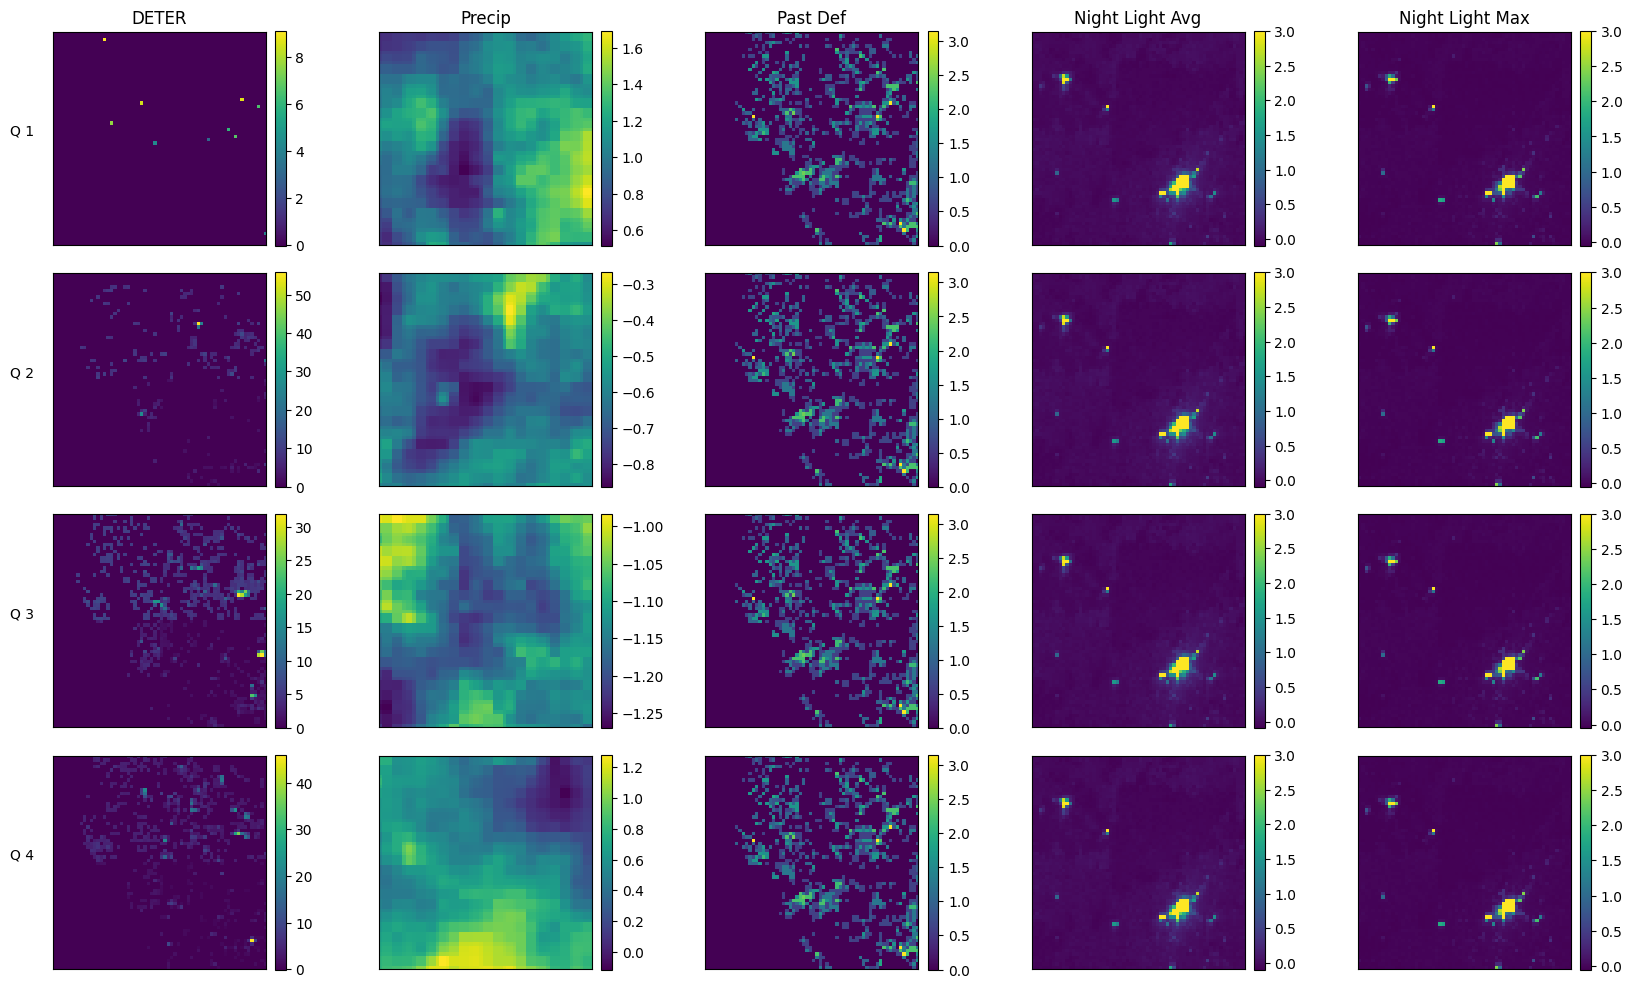

In [62]:
# Assuming you have your tensor
# # Generate sample data for five images (each with one channel)
idx_b = 10
tensor_data = batch_x[idx_b]

# Convert the PyTorch tensor to a NumPy array
numpy_data = tensor_data
print(numpy_data.shape)
print(image6_pred.shape)

# numpy_data = np.concatenate(numpy_data, image6_pred)

# Get the shape of the tensor
time_steps, rows, height, width = numpy_data.shape

# Reshape the tensor for plotting
reshaped_data = np.reshape(numpy_data, (time_steps * rows, height, width))

# Plot the images
hspace = 0.0
fig, axes = plt.subplots(nrows=time_steps, ncols=rows, figsize=(16, 10))

# # Set aspect ratio to be equal
# for ax in axes.flat:
#     ax.set(aspect='equal')
    
legend = ['DETER', 'Precip', 'Past Def', 'Night Light Avg', 'Night Light Max', 'Pred']
for t in range(time_steps):
    for r in range(rows):
        im = axes[t, r].imshow(reshaped_data[t * rows + r], cmap='viridis')
        # axes[t, r].axis('off')  # Turn off axis labels for clarity
        axes[0, r].set_title(legend[r])
        fig.colorbar(im, ax=axes[t, r], orientation='vertical', fraction=0.046, pad=0.04)
        
        # # Add titles for each row
        # if r == 0:
        #     axes[t, r].set_ylabel(f'Time Step {t + 1}', rotation=0, labelpad=15)

        # Remove axis ticks and labels
        axes[t, r].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=True)
        axes[t, 0].set_ylabel(f'Q {t + 1}', rotation=0, labelpad=15)
        
        # Remove y-axis tick labels (numbers) for rows other than the first row
        # if r != 0:
        axes[t, r].set_yticklabels([])
    
# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
# Adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.05, top=0.95)
plt.show()
fig.savefig(f'/home/thiago/AmazonDeforestation_Prediction/OpenSTL/tst_data_sample_input{idx_b}.jpg', dpi=300, bbox_inches='tight')

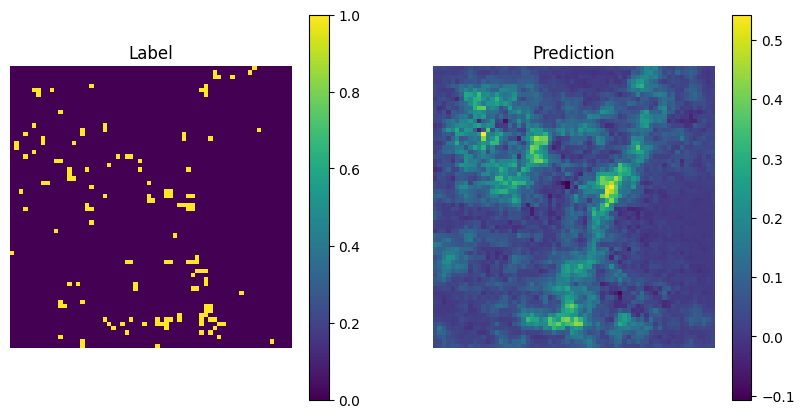

In [47]:
# Assuming you have image data
image6 = batch_y[idx_b, 0, 0]  # Replace this with your actual image data
image6_pred = pred_y[idx_b, 0, 0].cpu().detach().numpy()

# Plotting side by side with colorbar
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot image6
im1 = axes[0].imshow(image6, cmap='viridis')  # Change the colormap if needed
axes[0].set_title('Label')
axes[0].axis('off')

# Plot colorbar for image6
cbar1 = fig.colorbar(im1, ax=axes[0])

# Plot image6_pred
im2 = axes[1].imshow(image6_pred, cmap='viridis')  # Change the colormap if needed
axes[1].set_title('Prediction')
axes[1].axis('off')

# Plot colorbar for image6_pred
cbar2 = fig.colorbar(im2, ax=axes[1])

plt.show()
fig.savefig(f'/home/thiago/AmazonDeforestation_Prediction/OpenSTL/tst_data_sample_pred{idx_b}.jpg', dpi=300, bbox_inches='tight')
